# invert synthetic data using different parameterizations

## Intro : imports, prompt help

In [1]:
import sys, glob, os
from srfpython import *
try:
    check_herrmann_codes()
except Exception:
    recompile_src90(yes=False)
    check_herrmann_codes()

In [2]:
rm -rf _HerrMet* *.surf96 *.mod96

In [3]:
ls ./*

./tutorial1.ipynb


In [4]:
%run -i ../../srfpython/bin/HerrMet -h

HerrMet V6.0
# ----------------------------------------------------
-w           i       set the number of virtual workers to use for all parallelized processes, default None
-taskset     s       change job affinity for all parallelized processes, default None
-agg                 use agg backend (no display) if mentioned
-lowprio             run processes with low priority if mentioned
-inline              replace showme by plt.show (e.g. jupyter)
-verbose off         reduce verbosity
-cmap                colormap, default gray
# ----------------------------------------------------
--version, -v        display version and quit
--help, -h           display this help message, and quit
--example, -ex       display an example of script, and quit
--target     s [s..] set the target dispersion curve(s) from surf96 file(s) (not modified)
                     for each target, I create a directory in . for temporary files
                     the data will be reproduced into a target file that

## I/ Create synthetic data

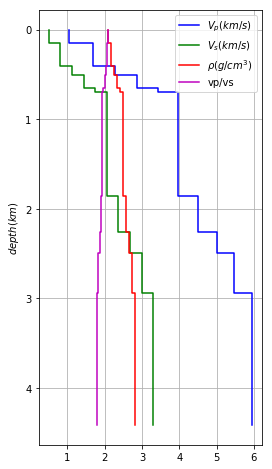

In [5]:
# -----------------
# generate a random depth model
# -----------------
ztop = np.unique(np.sort(np.random.rand(10))) * 3.
ztop[0] = 0.
vs   = np.linspace(.5, 3.3, len(ztop))
pr   = np.linspace(2.1, 1.8, len(ztop))
rh   = np.linspace(2.1, 2.8, len(ztop))
vp = np.array(pr) * np.array(vs)

dm = depthmodel_from_arrays(ztop, vp, vs, rh)
plt.figure(figsize = (4,8))
dm.show(gca())
dm.pr().show(gca(), color = "m", label="vp/vs")
gca().grid(True)
plt.legend()

dm.write96('dmtuto.mod96')

dmtuto.mod96 => dmtuto.surf96
dmtuto.surf96
    Ulaw wave=L mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=L mode=1 type=U flag=T extrapmode=1 N=6
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=R mode=1 type=U flag=T extrapmode=1 N=6


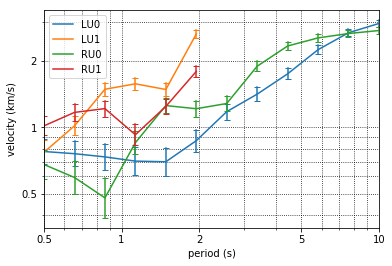

In [6]:
# -----------------
# compute the corresponding dispersion curves
# -----------------

os.system('rm -f dmtuto.surf96')
%run -i ../../srfpython/bin/m96 \
    --disp dmtuto.mod96 \
        -RU0 .1  2. 12 "log" \
        -LU0 .1  2. 12 "log" \
        -RU1 .1  2. 12 "log" \
        -LU1 .1  2. 12 "log" \
        -save dmtuto.surf96
        
%run -i ../../srfpython/bin/s96 \
    --show dmtuto.surf96 \
        -inline        


## II/ Invert data with 3 different parameterizations (2, 3, or 4 layers)

In [7]:
# -----------------
# clean up, prepare files for 3 inversions
# dmtuto.mod96 = synthetic model (the expected solution)
# dmtuto.surf96 = synthetic data (the data to invert)
# we generate 3 copies of dmtuto.surf96, to be used as targets by HerrMet
# -----------------
os.system('''
rm -rf _HerrMet*
mv dmtuto.surf96  2layers.surf96 #target 1
cp 2layers.surf96 3layers.surf96 #target 2
cp 2layers.surf96 4layers.surf96 #target 3
''')
for _ in glob.glob('./*'):
    print _, 


./2layers.surf96 ./dmtuto.mod96 ./3layers.surf96 ./4layers.surf96 ./tutorial1.ipynb


In [8]:
# -----------------
# set target data, create temporary directories (1 per target file)
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --target ?layers.surf96 \
        -lunc .3 \
        -ot

writing _HerrMet_2layers/_HerrMet.target
writing _HerrMet_3layers/_HerrMet.target
writing _HerrMet_4layers/_HerrMet.target
please keep only datapoints to invert in */_HerrMet.target
use option --display to see the target data


In [9]:
#ls -lrth ./*

_HerrMet_2layers/_HerrMet.target
    Ulaw wave=L mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=L mode=1 type=U flag=T extrapmode=1 N=6
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=12
    Ulaw wave=R mode=1 type=U flag=T extrapmode=1 N=6


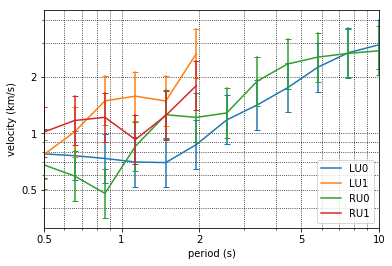

In [10]:
# show target (qc)
%run -i ../../srfpython/bin/s96 \
    --show _HerrMet_2layers/_HerrMet.target \
        -inline

# Parameterization

In [11]:
# -----------------
# set parameterization template, with two layers (in ./_HerrMet.param)
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --param 2 3. \
        -t mZVSPRRH \
        -growing \
        -op \
    --send   
    
# the template file is no longer needed, 
# the next cells reproduce the file content in _HerrMet_*/_HerrMet.param    
os.system('rm -f ./_HerrMet.param') 

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.600000         2.500000
       PR1         1.600000         2.500000
       RH0         2.200000         2.700000
       RH1         2.200000         2.700000

please customize _HerrMet.param, do not change line orders and metadata
use option --display to see the depth boundaries
cp ./_HerrMet.param _HerrMet_4layers/
cp ./_HerrMet.param _HerrMet_2layers/
cp ./_HerrMet.param _HerrMet_3layers/


0

In [12]:
# -----------------
# customize parameterization manually : 2 layers case
# -----------------
with open('_HerrMet_2layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       RH0         2.1              2.9
       RH1         2.1              2.9""")

In [13]:
# -----------------
# customize parameterization manually : 3 layers case
# -----------------
with open('_HerrMet_3layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 3
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -2.              -0.001000
       -Z3        -3.000000        -1.
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       PR2         1.79             2.12       
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9""")
#%run -i ../../srfpython/bin/HerrMet \
#    --display _HerrMet_3layers \
#        -m96 dmtuto.mod96 \
#        -inline

In [14]:
# -----------------
# customize parameterization manually : 4 layers case
# -----------------
with open('_HerrMet_4layers/_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -1.000000        -0.001000
       -Z2        -2.000000        -0.500000
       -Z3        -3.000000        -1.000000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       VS3         0.100000         3.500000
       PR0         1.79             2.12       
       PR1         1.79             2.12       
       PR2         1.79             2.12       
       PR3         1.79             2.12          
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9
       RH3         2.1              2.9""")

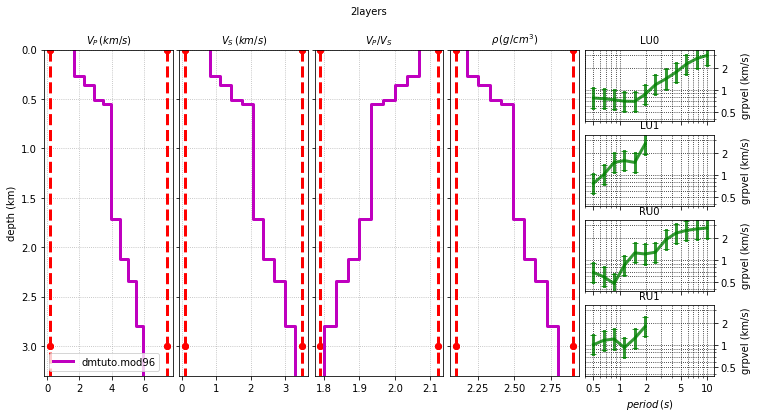

In [15]:
# check parameterizations for all 3 parameterizations
#%run -i ../../srfpython/bin/HerrMet \
#    --display \
#        -m96 dmtuto.mod96 \
#        -inline

# check parameterizations for 2 layers only
%run -i ../../srfpython/bin/HerrMet \
    --display _HerrMet_2layers \
        -m96 dmtuto.mod96 \
        -inline

In [16]:
# -----------------
# run all inversions (1 by 1) in restart mode
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -w 4\
    -taskset "0-3" \
    -verbose off \
    --run \
        -nchain 16 \
        -nkeep 200 
print "DONE"

chain    2  DONE kept  200/  920 fail   94 AK 0.22 MP 0.33 AS  24.05/s LI -3.080480
chain    0  DONE kept  200/  935 fail   85 AK 0.21 MP 0.30 AS  23.89/s LI -2.567074
chain    3  DONE kept  200/  890 fail   44 AK 0.22 MP 0.40 AS  22.67/s LI -1.412880
chain    1  DONE kept  200/  956 fail   93 AK 0.21 MP 0.24 AS  23.97/s LI -8.220238
chain    6  DONE kept  200/  953 fail  151 AK 0.21 MP 0.25 AS  27.69/s LI -5.282569
chain    4  DONE kept  200/  940 fail   81 AK 0.21 MP 0.28 AS  25.83/s LI -4.725269
chain    7  DONE kept  200/  975 fail  113 AK 0.20 MP 0.20 AS  26.80/s LI -14.342804
chain    5  DONE kept  200/  962 fail   56 AK 0.21 MP 0.23 AS  25.34/s LI -3.520844
chain    9  DONE kept  200/  941 fail  134 AK 0.21 MP 0.28 AS  27.99/s LI -3.466934
chain   10  DONE kept  200/  894 fail   71 AK 0.22 MP 0.41 AS  26.19/s LI -2.409096
chain    8  DONE kept  200/  977 fail   85 AK 0.20 MP 0.19 AS  26.36/s LI -24.088832
chain   11  DONE kept  200/  951 fail  114 AK 0.21 MP 0.26 AS  27.48/s LI 

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 1.173899s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 3215 models in 2.015328s 
Stacker Worker-0004 stacked    803 jobs in 0.853784s
Stacker Worker-0003 stacked    786 jobs in 0.851347s
Stacker Worker-0001 stacked    823 jobs in 0.867875s
Stacker Worker-0002 stacked    803 jobs in 0.874290s


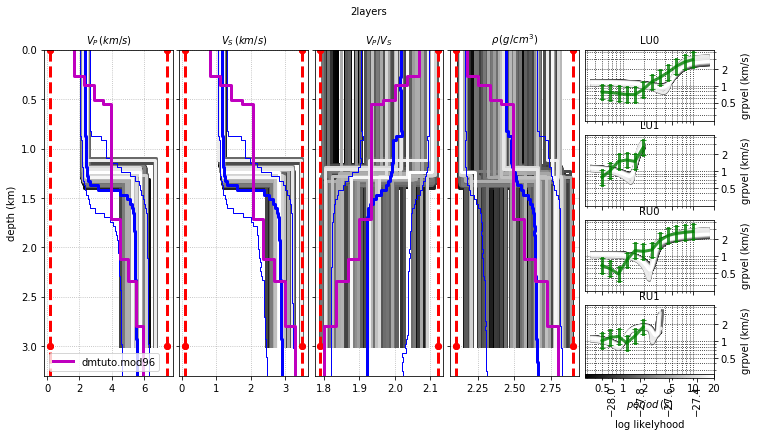

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 1.240214s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 3019 models in 1.636158s 
Stacker Worker-0004 stacked    788 jobs in 0.767596s
Stacker Worker-0001 stacked    772 jobs in 0.786276s
Stacker Worker-0002 stacked    769 jobs in 0.773497s
Stacker Worker-0003 stacked    690 jobs in 0.779239s


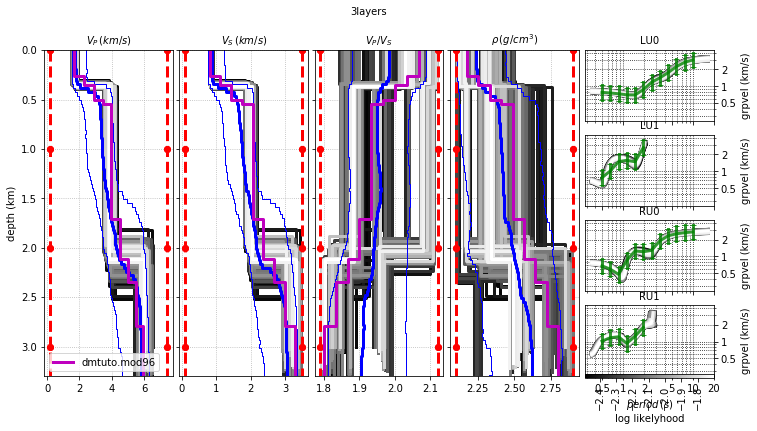

top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 1.320954s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 3210 models in 1.768007s 
Stacker Worker-0002 stacked    788 jobs in 1.154693s
Stacker Worker-0004 stacked    807 jobs in 1.134962s
Stacker Worker-0003 stacked    808 jobs in 1.138842s
Stacker Worker-0001 stacked    807 jobs in 1.150209s


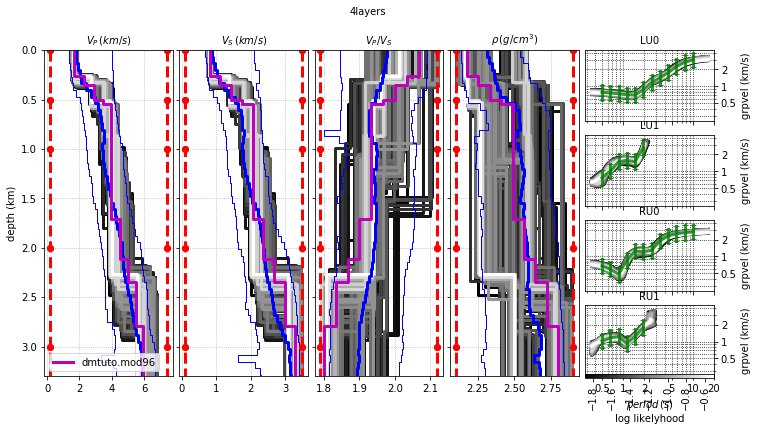

In [19]:
# -----------------
# display results
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -verbose off \
    --display _HerrMet_2layers _HerrMet_3layers _HerrMet_4layers \
        -top 0. 200 1 \
        -overdisp \
        -cmap gray \
        -pdf  \
        -m96 dmtuto.mod96 \
        -inline

In [22]:
#clean up
rm -rf *surf96 *mod96 _HerrMet*

In [23]:
ls ./*

./tutorial1.ipynb
